# Lab 6 by Boying Li (boylil-3)

Some notes taken from the paper:

The spectral radius ρ(W) of a matrix W is the largest absolute value of its eigenvalues. It scales the matrix W. In practice ρ(W) should be selected to maximize the performance, with the value 1 serving as an initial reference point.

Input scaling determines how nonlinear the reservoir responses are. For very linear tasks Win
should be small, letting units operate around the 0 point where their activation tanh(·) is virtually
linear. For large Win, the units will get easily saturated close to their 1 and −1 values, acting in
a more nonlinear, binary switching manner.

# Implement ESN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

In [64]:
class ESN:
  '''
  step 1-4 text is copied from the paper
  '''
  def __init__(self, in_size, out_size, reservoir_size, rho_scale=1, input_scale=1.0):

    self.in_size = in_size
    self.out_size = out_size
    self.reservoir_size = reservoir_size

    # 1.generate a large random reservoir RNN
    self.W_in = np.random.uniform(-1, 1, (reservoir_size, in_size+1))*input_scale #in_size+1 add bias input neuron
    self.W_out = np.zeros((out_size, reservoir_size))

    self.W = np.random.uniform(-1, 1, (reservoir_size, reservoir_size))
    self.W = self.W * (rho_scale/max(np.abs(np.linalg.eigvals(self.W))))
    # self.W *= rho_scale/max(abs(linalg.eig(self.W)[0]))

    self.x = np.zeros((reservoir_size,1))



  # 2. run it using the training input u(n) and collect the corresponding reservoir activation states x(n)
  # From paper: The typical update equations are x(n) = tanh(W_in[1;u(n)]+Wx(n-1))
  def run(self, input):
    # input_bias = np.append(input, 1)
    input_bias = np.vstack((1,input))
    self.x = np.tanh(np.dot(self.W_in, input_bias) + np.dot(self.W, self.x))
    return self.x


  # 3. compute the linear readout weights Wout from the reservoir using linear regression, minimizing the MSE between y(n) and ytarget(n);
  # only W_out will be updated during training, W_in and W will remain fixed
  def train(self, input, Y, discard_len, reg=1e-6):
    reservoir_states = np.zeros((1+self.in_size + self.reservoir_size, len(input)-discard_len))
    for t in range(len(input)):
      self.x = self.run(input[t])
      if t >= discard_len:
        reservoir_states[:,t-discard_len] = np.vstack((1,input[t], self.x))[:,0]

    print('x', self.x.shape)
    print('reservoir_states', reservoir_states.shape)
    print('reservoir_states.T', reservoir_states.T.shape)
    print('Y', Y.shape)
    # use scipy.linalg.solve to solve the linear regression:
    self.W_out = linalg.solve(np.dot(reservoir_states, reservoir_states.T) + reg*np.eye(reservoir_size+1 + self.in_size), np.dot(reservoir_states,Y.T)).T


  # use the trained network on new input data u(n) computing y(n) by employing the trained output weights Wout
  # From paper: The linear readout layer is defined as y(n) = Wout[1; u(n); x(n)]
  def predict(self, input):
    predictions = np.zeros((self.out_size, len(input)))
    for t in range(len(input)):
      self.x = self.run(input[t])
      prediction = np.dot(self.W_out, np.vstack((1,input[t], self.x)))
      predictions[:t] = prediction
    return predictions

  def test(self, test_data, Y_test):
    ys = np.zeros((self.out_size, len(test_data)))
    test_input = test_data[0]
    for t in range(len(test_data)):
      x = self.run(test_input)
      y = np.dot(self.W_out, np.vstack((1,test_input,x)))
      ys[:,t] = y
      # In the operating phase, the network acts as the generator of the signal
      # (thanks to trained readout matrix) feeding its previous prediction (at time
      # n−1) back to the reservoir.
      test_input = y

    # compute MSE for the first errorLen time steps
    mse = sum(np.square(test_data - ys[0])) / len(test_data)
    return ys, mse








In [33]:
# Example usage
def generate_data(n):
    x = np.linspace(0, 10, n)
    y = np.sin(x)
    return x, y

# Generate synthetic data
input_data, output_data = generate_data(500)

# Initialize and train ESN
input_size = 1
reservoir_size = 100
output_size = 1

output_data_1 = output_data[None,:]

In [ ]:
input_data.shape, output_data.shape

((500,), (1, 500))

x (100, 1)
reservoir_states (102, 500)
reservoir_states.T (500, 102)
Y (500,)


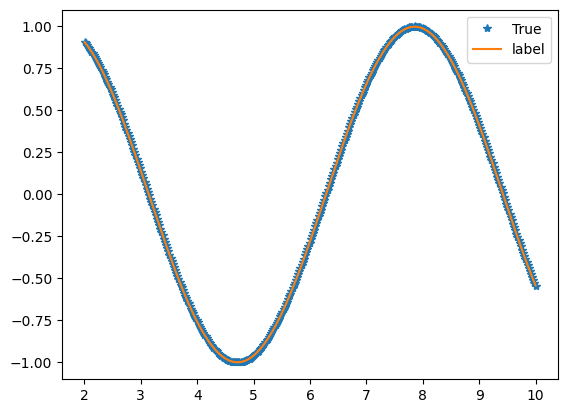

In [36]:
esn = ESN(input_size, output_size, reservoir_size)
esn.train(input_data, output_data)

# Predict using the trained ESN
predicted = esn.predict(input_data)
plt.plot(input_data[100:], output_data[100:], '*',label='True')
plt.plot(input_data[100:], predicted[100:], label='label')
plt.legend()
plt.show()

Computing spectral radius...
done.
MSE = 1.0233301599492538e-06


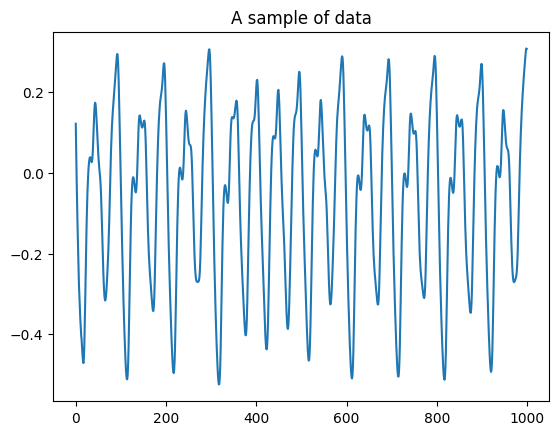

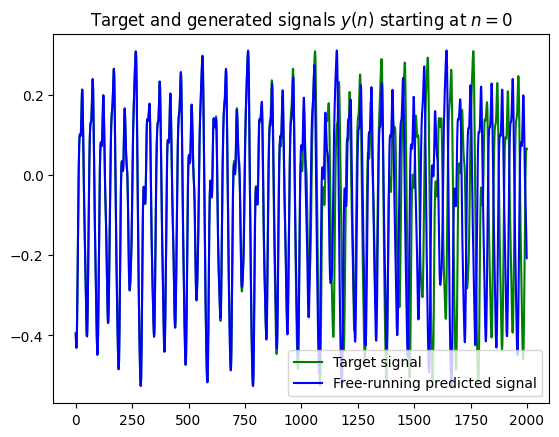

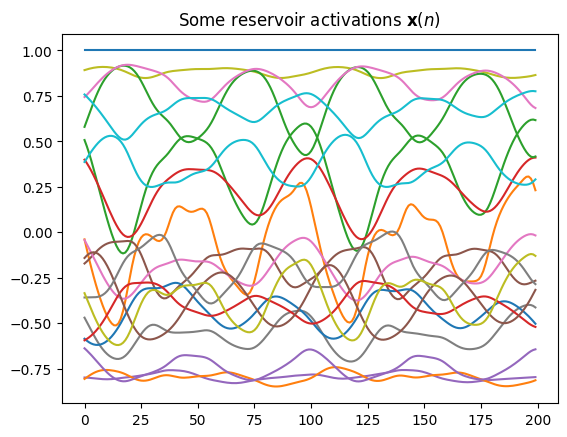

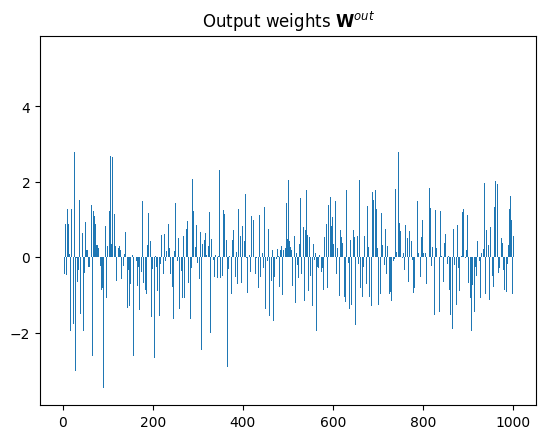

In [ ]:
# load the data
trainLen = 2000
testLen = 2000
initLen = 100
data = np.loadtxt('mg.txt')

# plot some of it
plt.figure(10).clear()
plt.plot(data[:1000])
plt.title('A sample of data')

# generate the ESN reservoir
inSize = outSize = 1
resSize = 1000
a = 0.3 # leaking rate
np.random.seed(42)
Win = (np.random.rand(resSize,1+inSize) - 0.5) * 1
W = np.random.rand(resSize,resSize) - 0.5
# normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...')
rhoW = max(abs(linalg.eig(W)[0]))
print('done.')
W *= 1.25 / rhoW

# allocated memory for the design (collected states) matrix
X = np.zeros((1+inSize+resSize,trainLen-initLen))
# set the corresponding target matrix directly
Yt = data[None,initLen+1:trainLen+1]

# run the reservoir with the data and collect X
x = np.zeros((resSize,1))
for t in range(trainLen):
    u = data[t]
    x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    if t >= initLen:
        X[:,t-initLen] = np.vstack((1,u,x))[:,0]

# train the output by ridge regression
reg = 1e-8  # regularization coefficient
# direct equations from texts:
#X_T = X.T
#Wout = np.dot( np.dot(Yt,X_T), linalg.inv( np.dot(X,X_T) + \
#    reg*np.eye(1+inSize+resSize) ) )
# using scipy.linalg.solve:
Wout = linalg.solve( np.dot(X,X.T) + reg*np.eye(1+inSize+resSize),
    np.dot(X,Yt.T) ).T

# run the trained ESN in a generative mode. no need to initialize here,
# because x is initialized with training data and we continue from there.
Y = np.zeros((outSize,testLen))
u = data[trainLen]
for t in range(testLen):
    x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    y = np.dot( Wout, np.vstack((1,u,x)) )
    Y[:,t] = y
    # generative mode:
    u = y
    ## this would be a predictive mode:
    #u = data[trainLen+t+1]

# compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( np.square( data[trainLen+1:trainLen+errorLen+1] -
    Y[0,0:errorLen] ) ) / errorLen
print('MSE = ' + str( mse ))

# plot some signals
plt.figure(1).clear()
plt.plot( data[trainLen+1:trainLen+testLen+1], 'g' )
plt.plot( Y.T, 'b' )
plt.title('Target and generated signals $y(n)$ starting at $n=0$')
plt.legend(['Target signal', 'Free-running predicted signal'])

plt.figure(2).clear()
plt.plot( X[0:20,0:200].T )
plt.title(r'Some reservoir activations $\mathbf{x}(n)$')

plt.figure(3).clear()
plt.bar( np.arange(1+inSize+resSize), Wout[0].T )
plt.title(r'Output weights $\mathbf{W}^{out}$')

plt.show()

# Modeling of dynamic systems with ESN

# Sinusoidal signal

In [49]:
def sinusoidal(n):
    x = np.linspace(0,n,n)
    y = 0.5*np.sin(x/4)
    return x, y

n = 4000
len_train = 3000
len_test = 1000
timestep, sin_input = sinusoidal(n)

# Initialize and train ESN
input_size = 1
reservoir_size = 1000
output_size = 1
discard_len = 1000
sin_train_x = sin_input[:len_train]
sin_train_y = sin_input[discard_len+1:len_train+1]

sin_test_x = sin_input[len_train:]
sin_test_y = sin_input[len_train+1:]

In [50]:
esn = ESN(input_size, output_size, reservoir_size, 0.8, 0.2)
esn.train(sin_train_x, sin_train_y, 1000)

predicted_test, test_mse = esn.test(sin_test_x, sin_test_y)

x (1000, 1)
reservoir_states (1002, 2000)
reservoir_states.T (2000, 1002)
Y (2000,)


In [51]:
predicted_test.shape, test_mse

((1, 1000), 0.007800684122664455)

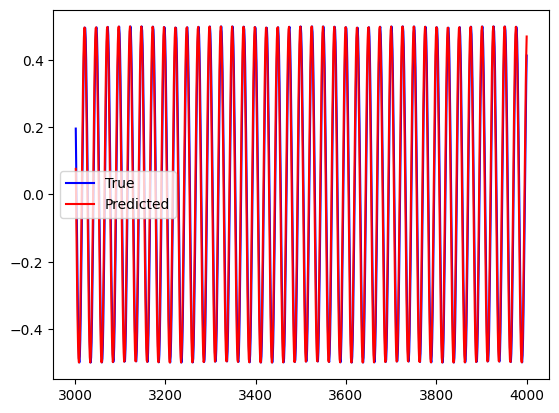

In [56]:
plt.plot(timestep[len_train+1:], sin_test_y, 'b', label='True')
plt.plot(timestep[len_train+1:], predicted_test[0,1:], 'r', label='Predicted')
plt.legend()
plt.show()

# Mackey-glass

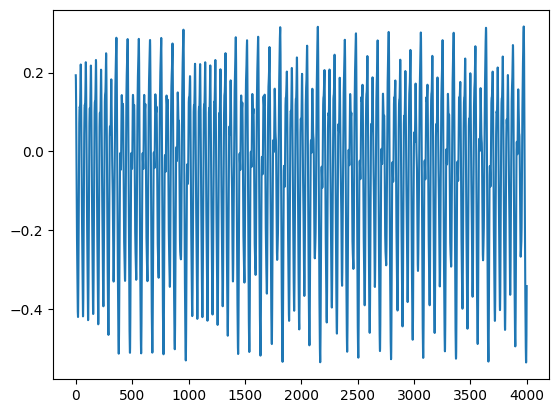

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# check for intuition at http://users.fs.cvut.cz/ivo.bukovsky/PVVR/prace_studentu/Mackey_Glass_time_series_prediction_Fuzzy_Lookup.pdf

def mackey_glass(tau, length):
    betta=0.2
    gamma = 0.1
    a=10
    delay=100 # will cut these initial steps

    y=np.random.rand(tau) # random intial values between 0 and 1
    # Euler's method to solve the differential equation
    for t in range(tau-1, length+delay+tau-1):
        current= y[t] + ( betta * y[t-(tau-1)]   / ( 1 + np.power(y[t-(tau-1)], a)   )  ) - gamma*y[t]
        y=np.append(y, current)

    y=y-1 # get rid of mean
    y=np.tanh(y) # squeze with tanh

    return y[tau+delay:length+delay+tau] # return the last length elements


length=4000 # duration of the series
tau=17 # delay in the equation

y=mackey_glass(tau, length)
#plot generated time-series
plt.plot(y)
plt.show()

In [59]:
n = 4000
len_train = 3000
len_test = 1000
MG_input = mackey_glass(tau, length)

# Initialize and train ESN
input_size = 1
reservoir_size = 1000
output_size = 1
discard_len = 1000

MG_train_x = MG_input[:len_train]
MG_train_y = MG_input[discard_len+1:len_train+1]

MG_test_x = MG_input[len_train:]
MG_test_y = MG_input[len_train+1:]

In [60]:
esn = ESN(input_size, output_size, reservoir_size, 0.8, 0.2)
esn.train(MG_train_x, MG_train_y, 1000)

predicted_test, test_mse = esn.test(MG_test_x, MG_test_y)

x (1000, 1)
reservoir_states (1002, 2000)
reservoir_states.T (2000, 1002)
Y (2000,)


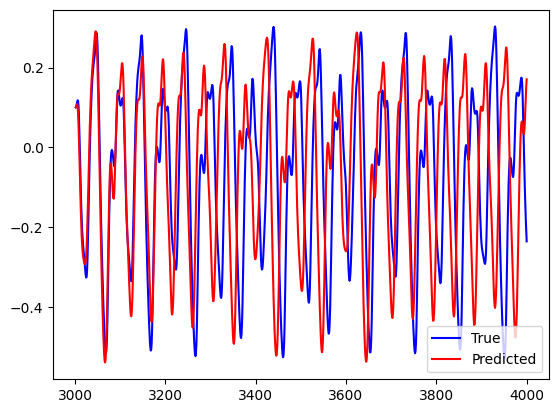

In [63]:
plt.plot(timestep[len_train+1:], MG_test_y, 'b', label='True')
plt.plot(timestep[len_train+1:], predicted_test[0,1:], 'r', label='Predicted')
plt.legend()
plt.show()

# Time-series	classification with	ESN